In [24]:
pip install conllu

In [3]:
import conllu
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import spacy
from wordcloud import WordCloud
from scipy.stats import chi2_contingency
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
with open("en_gum-ud-train.conllu", "r", encoding="utf-8") as f:
    data = f.read()
sentences = conllu.parse(data)

In [5]:
nlp = spacy.load("en_core_web_sm")

In [45]:
def basic_stats(sentences):
    stats = {
        'n_sentences': len(sentences),
        'n_tokens': sum(len(sent) for sent in sentences),
        'avg_tokens_per_sent': round(sum(len(sent) for sent in sentences)/len(sentences), 2),
        'unique_lemmas': len(set(token['lemma'].lower() for sent in sentences for token in sent if token['lemma']))
    }
    return stats

In [7]:
stats = basic_stats(sentences)
print("Statistiques générales:")
for k, v in stats.items():
    print(f"- {k}: {v}")

Statistiques générales:
- n_sentences: 9520
- n_tokens: 166918
- avg_tokens_per_sent: 17.53
- unique_lemmas: 11972


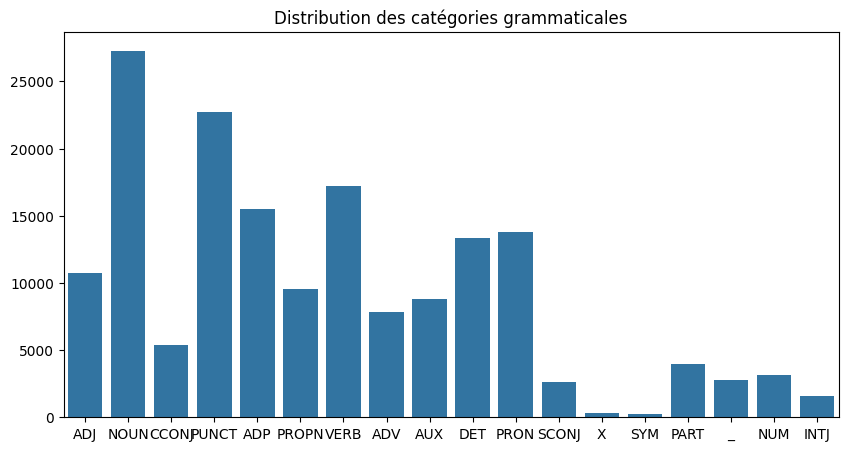

In [44]:
pos_counter = Counter(token['upostag'] for sent in sentences for token in sent)
plt.figure(figsize=(10,5))
sns.barplot(x=list(pos_counter.keys()), y=list(pos_counter.values()))
plt.title('Distribution des catégories grammaticales')
plt.show()


<ipython-input-42-161dcee6878d>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[v[1] for v in lemma_counter],


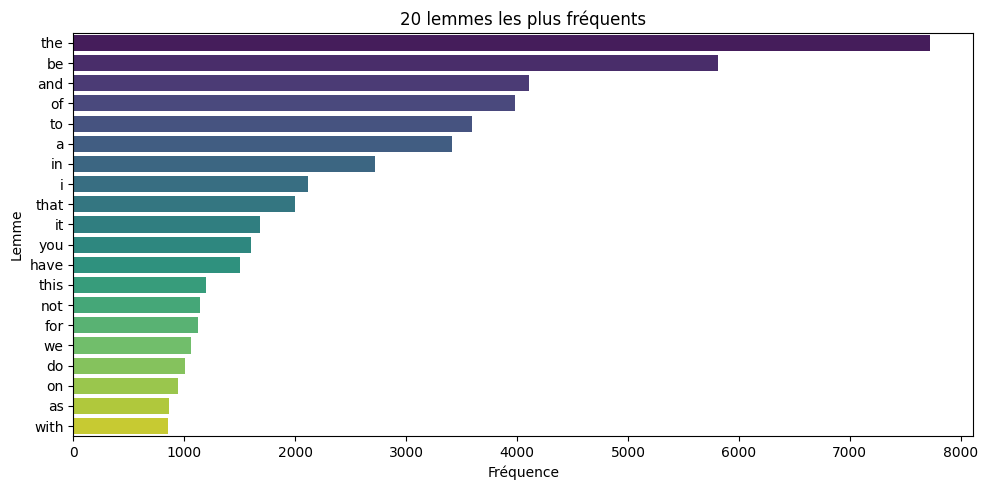

In [42]:
lemmas = [token['lemma'].lower()
          for sent in sentences
          for token in sent
          if token['upostag'] not in ['PUNCT', 'SYM']
          and token['lemma'] != '_']

lemma_counter = Counter(lemmas).most_common(20)

plt.figure(figsize=(10,5))
sns.barplot(x=[v[1] for v in lemma_counter],
            y=[v[0] for v in lemma_counter],
            palette="viridis")
plt.title('20 lemmes les plus fréquents')
plt.xlabel('Fréquence')
plt.ylabel('Lemme')
plt.tight_layout()
plt.show()

In [10]:
def analyze_morph(sentences):
    tense = Counter()
    gender = Counter()
    for sent in sentences:
        for token in sent:
            feats = token['feats']
            if feats:
                if 'Tense' in feats:
                    tense[feats['Tense']] += 1
                if 'Gender' in feats:
                    gender[feats['Gender']] += 1
    return tense, gender

In [11]:
tense, gender = analyze_morph(sentences)
print("\nTemps verbaux:", tense)
print("Genres grammaticaux:", gender)


Temps verbaux: Counter({'Pres': 9769, 'Past': 7412})
Genres grammaticaux: Counter({'Neut': 1884, 'Masc': 1121, 'Fem': 624, 'Fem,Masc': 3})


#Analyse Syntaxique


In [12]:
deprel_counter = Counter(token['deprel'] for sent in sentences for token in sent)
print("\nTop relations de dépendance:", deprel_counter.most_common(10))



Top relations de dépendance: [('punct', 22748), ('case', 15016), ('det', 12847), ('nsubj', 11953), ('root', 9520), ('amod', 8502), ('advmod', 8201), ('obj', 7303), ('obl', 7268), ('nmod', 6342)]


In [13]:
def get_pos_ngrams(sentences, n=3):
    ngrams = Counter()
    for sent in sentences:
        pos = [token['upostag'] for token in sent]
        for i in range(len(pos)-n+1):
            ngrams[tuple(pos[i:i+n])] += 1
    return ngrams

In [14]:
pos_trigrams = get_pos_ngrams(sentences).most_common(10)
print("\nStructures syntaxiques fréquentes (POS trigrammes):", pos_trigrams)



Structures syntaxiques fréquentes (POS trigrammes): [(('ADP', 'DET', 'NOUN'), 3189), (('DET', 'ADJ', 'NOUN'), 2417), (('NOUN', 'ADP', 'DET'), 2280), (('DET', 'NOUN', 'ADP'), 2265), (('ADJ', 'NOUN', 'PUNCT'), 2167), (('DET', 'NOUN', 'PUNCT'), 1956), (('VERB', 'DET', 'NOUN'), 1812), (('NOUN', 'ADP', 'NOUN'), 1605), (('ADJ', 'NOUN', 'ADP'), 1493), (('_', 'PRON', 'AUX'), 1411)]


In [17]:
dep_length_list = [
    abs(token["head"] - i)
    for sent in sentences
    for i, token in enumerate(sent)
    if token.get("head") is not None and isinstance(token["head"], int) and token["head"] > 0
]
print(f"\nLongueur moyenne des dépendances: {sum(dep_length_list)/len(dep_length_list):.2f}")




Longueur moyenne des dépendances: 3.58


In [18]:
roots = [token['lemma'] for sent in sentences for token in sent if token['deprel'] == 'root']
print("\nVerbes racines fréquents:", Counter(roots).most_common(10))


Verbes racines fréquents: [('have', 288), ('be', 227), ('say', 192), ('know', 143), ('think', 140), ('get', 137), ('go', 135), ('make', 116), ('take', 100), ('do', 92)]


##Analyse Discursive

In [19]:
connecteurs = {'however', 'therefore', 'moreover', 'because', 'although', 'thus', 'nevertheless'}
connectors_genre = defaultdict(Counter)
for sent in sentences:
    genre = sent.metadata.get('genre', 'inconnu')
    for token in sent:
        if token['lemma'].lower() in connecteurs:
            connectors_genre[genre][token['lemma']] += 1


In [20]:
genres = list(connectors_genre.keys())
data = [list(connectors_genre[g].values()) for g in genres]
chi2, p, _, _ = chi2_contingency(data)
print(f"\nSignificativité des différences entre genres (connecteurs): p={p:.4f}")


Significativité des différences entre genres (connecteurs): p=1.0000


##Comparaisons entre Genres

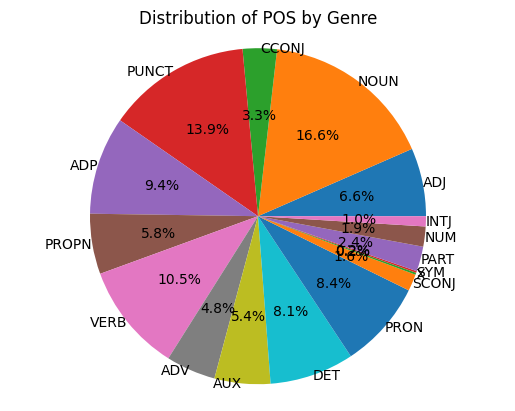

In [39]:
from pickle import NONE
pos_genre = defaultdict(lambda: defaultdict(int))
for sent in sentences:
    genre = sent.metadata.get('genre', 'inconnu')
    for token in sent:
        pos_genre[genre][token['upostag']] += 1

# Data preparation for pie chart
genre_pos_counts = defaultdict(int)
for genre, pos_counts in pos_genre.items():
    for pos, count in pos_counts.items():
        genre_pos_counts[(genre, pos)] += count

# Creating the pie chart
# Filter out labels containing '_'
labels = [f"{pos}" for genre, pos in genre_pos_counts.keys() if pos != '_']
sizes = [value for (genre, pos), value in genre_pos_counts.items() if pos != '_']

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%',labeldistance=1)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Distribution of POS by Genre')
plt.show()

In [31]:
print(labels)

['ADJ', 'NOUN', 'CCONJ', 'PUNCT', 'ADP', 'PROPN', 'VERB', 'ADV', 'AUX', 'DET', 'PRON', 'SCONJ', 'X', 'SYM', 'PART', '_', 'NUM', 'INTJ']


##Visualisations

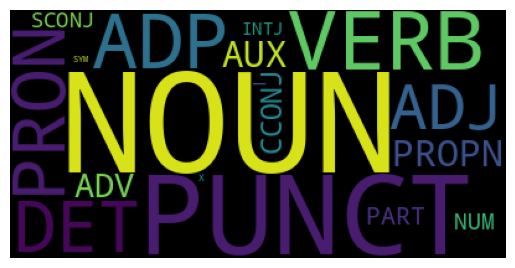

In [22]:
pos_cloud = WordCloud().generate_from_frequencies(pos_counter)
plt.imshow(pos_cloud)
plt.axis('off')
plt.show()


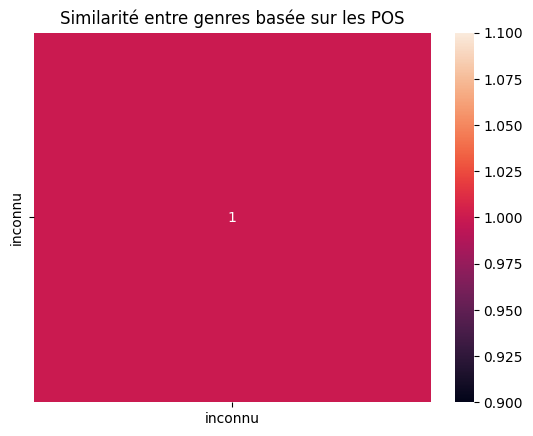

In [43]:
doc = nlp(" ".join([token['form'] for token in sentences[0]]))
spacy.displacy.render(doc, style='dep', options={'compact': True}, jupyter=False)

# E18. Similarité entre genres
similarity = cosine_similarity(df_pos.T)
sns.heatmap(similarity, annot=True, xticklabels=genres, yticklabels=genres)
plt.title('Similarité entre genres basée sur les POS')
plt.show()